# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 37

**Author 1 (sciper):** Michael Biselx    (283812)  
**Author 2 (sciper):** Bastien Darbellay (288406)   
**Author 3 (sciper):** Maria   Guerraoui (274578)  


**Release date:** 07.04.2022  
**Due date:** 25.04.2022


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [3]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data. Note that you do not need to solve the analytical expression. You can simply evaluate the function for each point on the plane to end up with a segmentation map.
For simplicity reasons, round the estimated parameters to the closest integer value.

In [170]:
# visualisation of the data (since it is low-dimensional data this is possible)
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline

def visualize_data(datas, lbls=[], stats=[], ax=[]): 
    colors = ['r', 'g', 'b', 'y']
    while len(lbls)  < len(datas) : lbls.append([])
    while len(stats) < len(datas) : stats.append([])  
    if ax==[] : fig, ax = plt.subplots(1,1, figsize=(10, 5))
        
    for data, lbl, stat, c in zip(datas, lbls, stats, colors) : 
        
        # plot scattering of data
        ax.scatter(data[:,0], data[:,1], s=1, color=c, label=lbl)
        
        # if statistics on the data are available
        if len(stat) : 
            # plot the mean
            ax.scatter(stat[0][0], stat[0][1], color=c)
            
            # plot the covariance 
            [v, w] = np.linalg.eig(stat[1])
            x = sorted(zip(v,w), reverse=True)
            v = [v for v,w in x]           # eigenvalues give the standard deviation
            w = x[0][1]                    # largest eigenvector gives the rotation of the semimajor axis
            semimaj = np.sqrt(5.991*v[0])  # 95% prdicition semimajor axis
            semimin = np.sqrt(5.991*v[1])  # 95% prdicition semiminor axis
            angle   = np.rad2deg(np.arctan2(w[1], w[0]))
            ellipse = Ellipse(stat[0], width =2*semimaj, height=2*semimin, angle=angle,
                              alpha=.2, facecolor=c)
            ax.add_artist(ellipse)
            
    ax.set_title("data visualisation")
    ax.legend()

data   = [a,b,c]
labels = ['a', 'b', 'c']
#visualize_data(data, labels)
#plt.show()

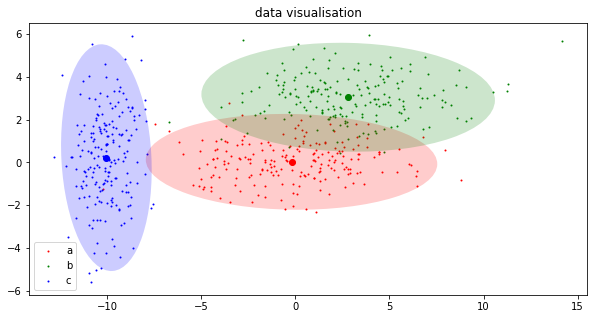

In [171]:
def get_stats(data) : 
    mean = np.mean(data, axis=0)
    cov  = np.cov(data, rowvar=False)
    return mean, cov

stats = [get_stats(d) for d in data]

visualize_data(data, labels, stats)
plt.show()

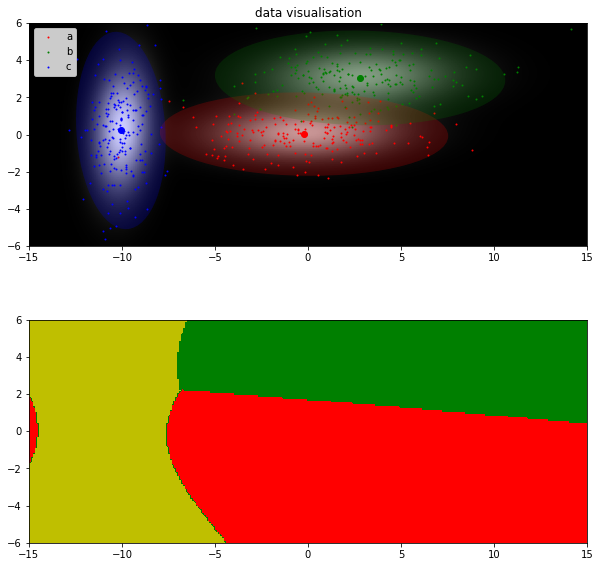

In [189]:
from scipy.stats import multivariate_normal

def partition_space(stats, x_range, y_range) : 
    X,Y = np.mgrid[x_range[0]:x_range[1]:0.1, y_range[0]:y_range[1]:0.1]
    grid = np.dstack((X, Y))
    
    mvns = [multivariate_normal(stat[0], stat[1]) for stat in stats]
    grid_probs = [mvn.pdf(grid) for mvn in mvns]
    
    partition = np.argmax(grid_probs, axis=0)
    
    return partition, grid_probs;
        

partition, probs = partition_space(stats, (-15, 15), (-6, 6))
P = probs[0] + probs[1] + probs[2]

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].imshow(P.T, origin='lower', extent=[-15, 15, -6, 6], cmap='gray')
visualize_data(data, labels, stats, axes[0])

#axes[1].imshow(partition.T, origin='lower', extent=[-15, 15, -6, 6])
#cmap = matplotlib.colors.ListedColormap(['r', 'g', 'b', 'y'])
#norm = matplotlib.colors.BoundaryNorm([0, 0.9, 1.9, 2.9], cmap.N, clip=True)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('blub', ['r', 'g', 'b', 'y'], 4)
axes[1].imshow(partition.T, origin='lower', extent=[-15, 15, -6, 6], cmap=cmap, norm=norm)


plt.show()

In [155]:
# Add your implementation and discussion


### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

In [ ]:
# Add your implementation and discussion

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [ ]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [ ]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [ ]:
# Add your implementation and discussion